In [1]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## Visualising Bayesian linear regression: Online learning

Previously we have introduced the [Bayesian approach to regression](regression_bayesian.ipynb) and visualised the resulting _predictive distribution_. In this section we visualise the _posterior distribution_ over the weights. By considering how the posterior evolves as data arrive one by one, we will develop an intuitive understanding of several important properties of Bayesian inference. 

The presentation also shows that probabilistic inference naturally provides so-called **online** or **incremental** updates. That is to say, an inference can be updated using the previous posterior distribution and the current data: it does not require the old data. Such updates are often faster and more memory efficient than **batch** updates which have to retain the whole dataset so that it can be accessed as new data arrive. They are particularly appealing when speed is important e.g. in high-frequency trading or in an autonomous robot that is continuously localising itself in an environment.    

### Recapitulating the model

Consider a scenario where we are fitting a regression model

\begin{align}
p(\mathbf{w},\mathbf{y},\mathbf{X} | \sigma_{\mathbf{w}}^2,\sigma_{y}^2) & = p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{X}) p(\mathbf{y}|\mathbf{X},\sigma_{y}^2) = p(\mathbf{w} | \sigma_{\mathbf{w}}^2) \prod_{n=1}^N p(x_n) p(y_n |\mathbf{w},\mathbf{x}_n,\sigma_{y}^2)\\
& = \mathcal{N}(\mathbf{w} ; \mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I}) \prod_{n=1}^N p(\mathbf{x}_n) \mathcal{N}(y_n; f^{(m)}_{\mathbf{w}}(\mathbf{x}),\sigma_{y}^2) \;\; \text{where} \;\; f_{\mathbf{w}}.(\mathbf{x})=\boldsymbol{\phi}(\mathbf{x})^\top \mathbf{w}.
\end{align}

We will suppress the parameters $\sigma_{\mathbf{w}}^2$ and $\sigma_y^2$ to lighten the notation.

### Inference through incremental updates

The data  $\{ \mathbf{x}_{n}, y_n \}$ arrive one after another and predictions are required after each datapoint is seen.  

Initially, before any data are seen, the prior $p(\mathbf{w})$ captures our knowledge about the weights $\mathbf{w}$. After one datapoint is observed Bayes' rule tells us that the posterior distribution over the weights is proportional to the prior times the likelihood from the datapoint:

$$
p(\mathbf{w}| y_1, \mathbf{x}_1) \propto p(\mathbf{w}) p(y_1| \mathbf{x}_1, \mathbf{w})
$$

After two datapoints are seen the posterior is equal to the prior times the likelihood from the two datapoints

$$
p(\mathbf{w}| y_1, \mathbf{x}_1,y_2, \mathbf{x}_2) \propto p(\mathbf{w}) p(y_1| \mathbf{x}_1, \mathbf{w}) p(y_2| \mathbf{x}_2, \mathbf{w}, \sigma_y^2)
$$

This can be rewritten in terms of the product of the posterior after seeing one datapoint and the likelihood from the second datapoint

$$
p(\mathbf{w}| y_1, \mathbf{x}_1,y_2, \mathbf{x}_2) \propto p(\mathbf{w}| y_1, \mathbf{x}_1) p(y_2| \mathbf{x}_2, \mathbf{w}).
$$

Here **the previous posterior $p(\mathbf{w}| y_1, \mathbf{x}_1)$ plays the role of the new prior**. In retrospect this seems obvious as it follows directly from Bayes' rule: combine what you know about the parameters before seeing a new data point (the previous posterior) with the information coming from the datapoint (the new likelihood). 

The extension to $N$ datapoints is straightforward,

$$
p(\mathbf{w}| \{y_{n}, \mathbf{x}_{n}\}^N_{n = 1}) \propto p(\mathbf{w}| \{y_{n}, \mathbf{x}_{n}\}^{N-1}_{n = 1}) p(y_N| \mathbf{x}_N, \mathbf{w}).
$$

At any point during the process the updated posterior can be used to make predictions in the usual way

$$
p(y^* | \mathbf{x}^*,  \{y_{n}, \mathbf{x}_{n}\}^N_{n = 1} ) = \int p(y^* | \mathbf{x}^*, \mathbf{w}) p(\mathbf{w}| \{y_{n}, \mathbf{x}_{n}\}^N_{n = 1}) d\mathbf{w}.
$$

The updating scheme above is called  _online_ or _incremental_ because it only requires the old posterior to be stored, and not the old data  $\{y_{n}, \mathbf{x}_{n}\}^{N-1}_{n = 1}$. Although the expressions were computed with regression in mind, they are very general.

### Visualisation

Let's implement this method for Bayesian straight line fitting, $y=w_0 + w_1 x_1 + \epsilon$ since this model has $2$ weights (the gradient and intercept) which we can easily visualise with a contour plot. At each step, will also draw $3$ weight samples from the posterior and plot the corresponding lines in data-space.

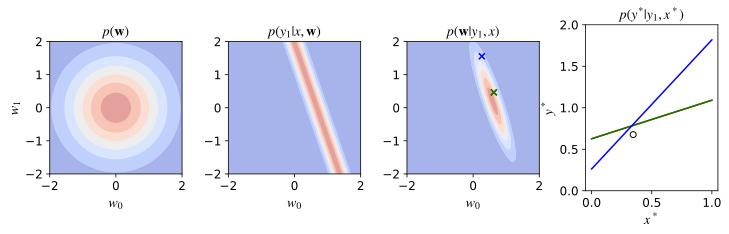

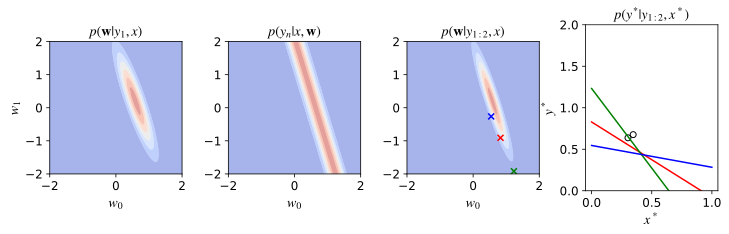

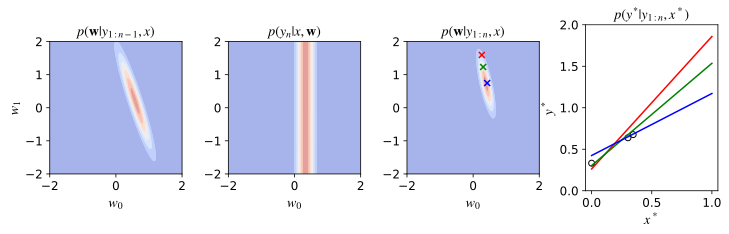

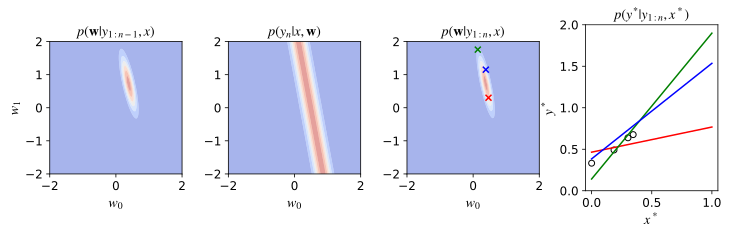

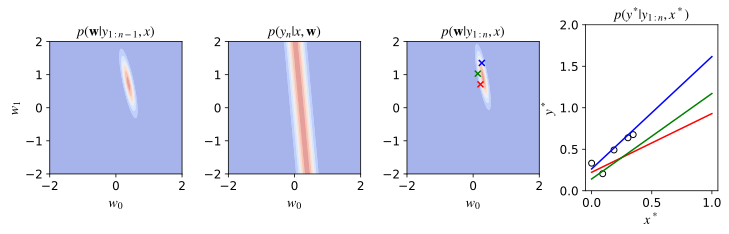

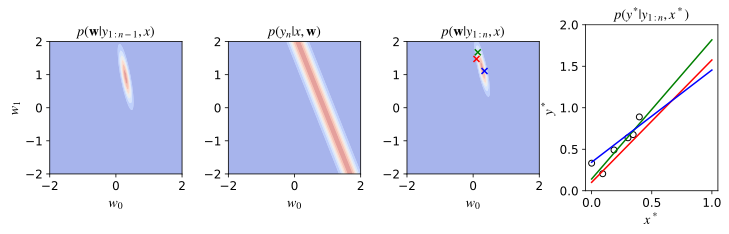

In [4]:
x_lin = np.load('reg_lin_x.npy')  
y_lin = np.load('reg_lin_y.npy') # loading the linear regression dataset into numpy arrays


w1_range, w2_range = np.linspace(-2, 2, 100), np.linspace(-2, 2, 100) # specify the range of weights to be visualised
w1, w2 = np.meshgrid(w1_range, w2_range) # returns two 2d arrays with the values of w1_range and w2_range (see docs!)
grid = np.stack([w1, w2], axis = 2) # stack the two grids together to do aritmetic elegantly later

var_w = 1
var_y = 0.03
no_points = 5 # do the algorithm for no_points sequential observations

colours = ['red', 'green', 'blue']
x_ = np.linspace(0, 1, 100)

for n in range(no_points + 1):

    X = np.array([[x_lin[n] ** d for d in range(0, 2)]]) # X contains a single point (x[n]) for online learning
    
    if n == 0:
        log_prior = -1/2*np.sum(grid.dot(np.eye(2) ) * grid, axis = 2)/ var_w # quadratic form of prior (goes in the exponent)
        
    log_lik = -1 / 2 *np.sum((y_lin[n] - grid.dot(X.T)) ** 2, axis = 2)/var_y # quadratic form of likelihood of (x[n], y[n]) point
    
    log_post = log_prior + log_lik # posterior is prior*lik by Bayes' rule

    fig = plt.figure(figsize = (12, 3)) # add new figure to plot this step
    for i, values in enumerate([np.exp(log_prior-np.amax(log_prior)), np.exp(log_lik-np.amax(log_lik)), np.exp(log_post-np.amax(log_post))]):
        sp = plt.subplot(1, 4, i + 1)
        plt.contourf(w1_range, w2_range, values, cmap = 'coolwarm', alpha = 0.5) # plot prior after n points
        sp.set_aspect('equal', 'box')
        
        if i == 0 and n ==0 :
            beautify_plot({"title":"$p(\mathbf{w})$", "x":"$w_0$", "y": '$w_1$'})
            
        if i == 1 and n ==0 :
             beautify_plot({"title":"$p(y_1|x,\mathbf{w})$", "x":"$w_0$"})

        if i == 2 and n ==0 :
             beautify_plot({"title":"$p(\mathbf{w}|y_1,x)$", "x":"$w_0$"})

        if i == 0 and n ==1 :
            
            beautify_plot({"title":"$p(\mathbf{w}|y_{1},x)$", "x":"$w_0$", "y": '$w_1$'})
            
        if i == 1 and n ==1 :
             beautify_plot({"title":"$p(y_n|x,\mathbf{w})$", "x":"$w_0$"})

        if i == 2 and n ==1 :
             beautify_plot({"title":"$p(\mathbf{w}|y_{1:2},x)$", "x":"$w_0$"})

         

        if i == 0 and n >1 :
            
            beautify_plot({"title":"$p(\mathbf{w}|y_{1:n-1},x)$", "x":"$w_0$", "y": '$w_1$'})
            
        if i == 1 and n >1 :
             beautify_plot({"title":"$p(y_n|x,\mathbf{w})$", "x":"$w_0$"})

        if i == 2 and n >1 :
             beautify_plot({"title":"$p(\mathbf{w}|y_{1:n},x)$", "x":"$w_0$"})

         
                
                
    w1s, w2s = [[],[]] # initialising 2 empty arrays to store old weights
    
    for i in range(3):
        post = np.exp(log_post)
        w1, w2 = sample_weights_from(w2_range, w1_range, post)
        w1s.append(w1)
        w2s.append(w2)
        plt.scatter(w1, w2, marker = 'x', color = colours[i])
        
    plt.subplot(144)
    for i in range(3):
        plt.plot(x_, w1s[i] + w2s[i] * x_, color = colours[i])
        #remove_axes()
    
    plt.scatter(x_lin[:n + 1], y_lin[:n + 1], marker = 'o', facecolor = 'None', edgecolor = 'black')
    plt.ylim([0, 2])  

    if n == 0:
        beautify_plot({"title":"$p(y^{*}|y_1,x^*)$", "x":"$x^*$", "y": "$y^*$"})

    if n == 1:
        beautify_plot({"title":"$p(y^{*}|y_{1:2},x^*)$", "x":"$x^*$", "y": "$y^*$"})
                
    if n > 1:
        beautify_plot({"title":"$p(y^{*}|y_{1:n},x^*)$", "x":"$x^*$", "y": "$y^*$"})
                            
    fig.subplots_adjust(wspace=0.35)
    
    log_prior = log_post.copy() # set prior of the next step to be the posterior of the current step

plt.show()

toggle_code()

The first row of figures above shows contour plots of the prior ($p(w_0,w_1)$, first plot, leftmost), the likelihood for the first datapoint ($p(y_1|x_1,w_0,w_1)$, second), and the posterior after seeing the first datapoint (p(w_0,w_1|x_1,y_1), third) plotted as a function of the intercept ($w_0$) and gradient ($w_1$). The fourth plot (rightmost) shows the datapoint $\{x_1,y_1\}$. Samples from the posterior distribution are shown by coloured crosses (third plot) and the corresponding straight lines are shown on the right. When one datapoint is seen, the settings of the weight corresponding to straight lines that pass close to the datapoint will have high mass under the posterior. In this instance, that is lines with positive gradient that have an intercept with a low value or lines with a negative gradient and a high valued intercept. This is the reason why the posterior is fairly diffuse - a single datapoint cannot pin down the parameters by itself - and correlated.

The second row of figures shows the same quantities once the second datapoint is observed. On the left is the 'prior' (the previous posterior), next is the likelihood for the new data point, then the posterior with three samples, and finally the data with the sampled straight lines. The new datapoint in this case has a similar input location to the old one, so it does not provide much additional information about the parameters. Notice though that the posterior has narrowed slightly as we become more confident.

The third datapoint (third row) does have a different input location from the other two. It consequently suggests that the line has positive graident and a relatively low value for the intercept. The posterior collapses, not largely confined to the postive quadrant. The posterior samples all have postive gradient. 

As more data arrive (lower rows) the posterior narrows down, and the weights are constrained to a progressively smaller area. This is caused by the likelihoods that act as soft constraints ruling out more and more of parameter space. This collapse is reflected in the data space where the lines corresponding to posterior samples show less variability.

You have now finished the regression notebooks. In the [next section](../classification/classification_intro.ipynb), on classification you will look at different approaches to the classification of data points.

### Summary


1. Bayesian updating naturally supports online or incremental updates: the old posterior is multiplied by the new likelihood and renormalised to get the new posterior
2. the posterior typically evolves from a diffuse initial prior, through to a concentrated posterior as more data arrive and the likelihood functions rule out many parameter settings  
